<a href="https://colab.research.google.com/github/Ajaysharma001/temperature-converter/blob/main/load_forecastingAjay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
from math import sqrt

In [7]:
# input part
def get_data():
    data = pd.read_csv('data123.csv.csv')
    df = pd.DataFrame(data)
    df.drop(df.columns[[0, 3, 7, 8]], axis=1, inplace=True)
    return df

In [8]:
# cleaning and spliting part
def load_data(data, seq_len):
    var_count = len(data.columns)
    data = data.values
    sequence_length = seq_len+1
    result = []
    for i in range(len(data)-sequence_length):
        result.append(data[i:i+sequence_length])
    result = np.array(result)
    row = round(0.8*result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:, -1]
    x_train = np.reshape(
        x_train, (x_train.shape[0], x_train.shape[1], var_count))
    x_test = np.reshape(
        x_test, (x_test.shape[0], x_test.shape[1], var_count))
    print(x_train[:3])
    print(y_train[:3])
    return [x_train, y_train, x_test, y_test]

In [9]:
# building of untrained data
def build_model(layers):
    model = Sequential()
    model.add(LSTM(50, input_shape=(
        layers[1], layers[0]), return_sequences=False))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [10]:
df = get_data()
print(df)

       Day  Month  Hours  Temperature  Demand
0        1      1      0        6.800   61194
1        1      1   1800        6.710   59674
2        1      1   3600        6.620   57877
3        1      1   5400        6.530   57755
4        1      1   7200        6.440   57243
...    ...    ...    ...          ...     ...
70123   31     12  77400        1.390   71318
70124   31     12  79200        1.290   70793
70125   31     12  81000        1.215   71924
70126   31     12  82800        1.140   75424
70127   31     12  84600        1.100   75504

[70128 rows x 5 columns]


In [11]:
values = df.values
print(values)

[[1.0000e+00 1.0000e+00 0.0000e+00 6.8000e+00 6.1194e+04]
 [1.0000e+00 1.0000e+00 1.8000e+03 6.7100e+00 5.9674e+04]
 [1.0000e+00 1.0000e+00 3.6000e+03 6.6200e+00 5.7877e+04]
 ...
 [3.1000e+01 1.2000e+01 8.1000e+04 1.2150e+00 7.1924e+04]
 [3.1000e+01 1.2000e+01 8.2800e+04 1.1400e+00 7.5424e+04]
 [3.1000e+01 1.2000e+01 8.4600e+04 1.1000e+00 7.5504e+04]]


In [12]:
minima = np.amin(values[:, -1])
maxima = np.amax(values[:, -1])
scaling_parameter = maxima-minima

In [13]:
values[:, 4] = (values[:, 4] - minima) / scaling_parameter
values[:, 0] = (values[:, 0]-np.amin(values[:, 0])) / \
    (np.amax(values[:, 0])-np.amin(values[:, 0]))
values[:, 1] = (values[:, 1]-np.amin(values[:, 1])) / \
    (np.amax(values[:, 1])-np.amin(values[:, 1]))
values[:, 2] = (values[:, 2]-np.amin(values[:, 2])) / \
    (np.amax(values[:, 2])-np.amin(values[:, 2]))
values[:, 3] = (values[:, 3]-np.amin(values[:, 3])) / \
    (np.amax(values[:, 3])-np.amin(values[:, 3]))

In [14]:
df = pd.DataFrame(values)
window = 5
x_train, y_train, x_test, y_test = load_data(df[::-1], window)

[[[1.         1.         1.         0.1301536  0.72882886]
  [1.         1.         0.9787234  0.13123147 0.72756207]
  [1.         1.         0.95744681 0.13325249 0.67214023]
  [1.         1.         0.93617021 0.13527351 0.65423106]
  [1.         1.         0.91489362 0.1379682  0.66254434]]

 [[1.         1.         0.9787234  0.13123147 0.72756207]
  [1.         1.         0.95744681 0.13325249 0.67214023]
  [1.         1.         0.93617021 0.13527351 0.65423106]
  [1.         1.         0.91489362 0.1379682  0.66254434]
  [1.         1.         0.89361702 0.14066289 0.67928173]]

 [[1.         1.         0.95744681 0.13325249 0.67214023]
  [1.         1.         0.93617021 0.13527351 0.65423106]
  [1.         1.         0.91489362 0.1379682  0.66254434]
  [1.         1.         0.89361702 0.14066289 0.67928173]
  [1.         1.         0.87234043 0.14443546 0.70233722]]]
[0.67928173 0.70233722 0.73118824]


In [15]:
print(y_test)

[0.10699582 0.12588675 0.14390676 ... 0.44777679 0.44970864 0.4781638 ]


In [16]:
model = build_model([5, window, 1])

Compilation Time :  0.007955551147460938


In [17]:
print(x_train.shape)

(56098, 5, 5)


In [18]:
# training part, can also change batch size and epoch to get more better result
model.fit(
    x_train,
    y_train,
    batch_size=1024,
    epochs=100,
    validation_split=0.2,
    verbose=2
)

Epoch 1/100
44/44 - 4s - loss: 0.0494 - accuracy: 2.2283e-05 - val_loss: 0.0142 - val_accuracy: 0.0000e+00 - 4s/epoch - 91ms/step
Epoch 2/100
44/44 - 1s - loss: 0.0064 - accuracy: 2.2283e-05 - val_loss: 0.0051 - val_accuracy: 0.0000e+00 - 963ms/epoch - 22ms/step
Epoch 3/100
44/44 - 1s - loss: 0.0043 - accuracy: 2.2283e-05 - val_loss: 0.0042 - val_accuracy: 0.0000e+00 - 976ms/epoch - 22ms/step
Epoch 4/100
44/44 - 1s - loss: 0.0039 - accuracy: 2.2283e-05 - val_loss: 0.0037 - val_accuracy: 0.0000e+00 - 941ms/epoch - 21ms/step
Epoch 5/100
44/44 - 1s - loss: 0.0036 - accuracy: 2.2283e-05 - val_loss: 0.0038 - val_accuracy: 0.0000e+00 - 962ms/epoch - 22ms/step
Epoch 6/100
44/44 - 1s - loss: 0.0034 - accuracy: 2.2283e-05 - val_loss: 0.0036 - val_accuracy: 0.0000e+00 - 966ms/epoch - 22ms/step
Epoch 7/100
44/44 - 1s - loss: 0.0032 - accuracy: 2.2283e-05 - val_loss: 0.0034 - val_accuracy: 0.0000e+00 - 959ms/epoch - 22ms/step
Epoch 8/100
44/44 - 1s - loss: 0.0031 - accuracy: 2.2283e-05 - val_loss:

In [19]:
# function to calculate error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [20]:
# testing part
predicted = model.predict(x_test)
predicted = (predicted*scaling_parameter)+minima
actual = y_test
actual = (actual*scaling_parameter)+minima
print(actual)
print(predicted)

439/439 [==============================] - 1s 2ms/step
[36234. 37427. 38565. ... 57755. 57877. 59674.]
[[35948.027]
 [36880.605]
 [38286.293]
 ...
 [58410.457]
 [58972.58 ]
 [59206.062]]


In [21]:
mape = sqrt(mean_absolute_percentage_error(predicted, actual))
print("Test MAPE: %0.3f" % mape)

Test MAPE: 5.307


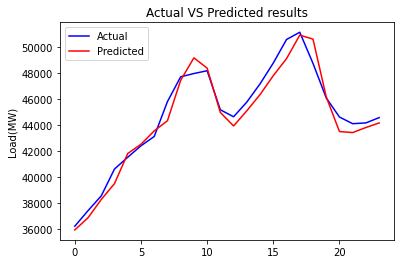

In [22]:
# result presenting part
plt.plot(actual[:24], label='Actual', color="blue")
plt.plot(predicted[:24], label='Predicted', color="red")
plt.ylabel("Load(MW)")
plt.title("Actual VS Predicted results")
plt.legend()
plt.show()